In [1]:
from spacerocks.spacerock import SpaceRock, RockCollection
from spacerocks.observing import Observatory, DetectionCatalog
from spacerocks.spice import SpiceKernel
from spacerocks.time import Time
from spacerocks.nbody import Simulation, Integrator

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

kernel = SpiceKernel()
kernel.load("/Users/kjnapier/data/spice/latest_leapseconds.tls")
kernel.load("/Users/kjnapier/data/spice/de440s.bsp")

In [2]:
N = 50
rocks = RockCollection.random(N)

epoch = Time.now()
rocks.analytic_propagate(epoch)

planets_names = ["sun", 
                 "jupiter barycenter", 
                 "saturn barycenter", 
                 "uranus barycenter", 
                 "neptune barycenter"]

planets = [SpaceRock.from_spice(name, epoch) for name in planets_names]

In [3]:
sim = Simulation()

sim.set_epoch(epoch)
sim.set_frame("ECLIPJ2000")
sim.set_origin("SSB")
sim.set_integrator(Integrator.leapfrog(timestep=20.0))

for planet in planets:
    sim.add(planet)
    
for rock in rocks:
    sim.add(rock)

sim.move_to_center_of_mass()
initial_energy = sim.energy()

In [6]:
dts = np.linspace(0, 365.25 * 1_000_000, 10_000)
epochs = [epoch + dt for dt in dts]

In [7]:
energies = []
particle_snapshots = []
perturber_snapshots = []

for epoch in epochs:
    sim.integrate(epoch)
    energies.append(sim.energy())
    particle_snapshots.append(sim.particles)
    perturber_snapshots.append(sim.perturbers)

In [8]:
for p in particle_snapshots:
    p.calculate_orbit()

(2460361.4763310184, 367710361.4763477)

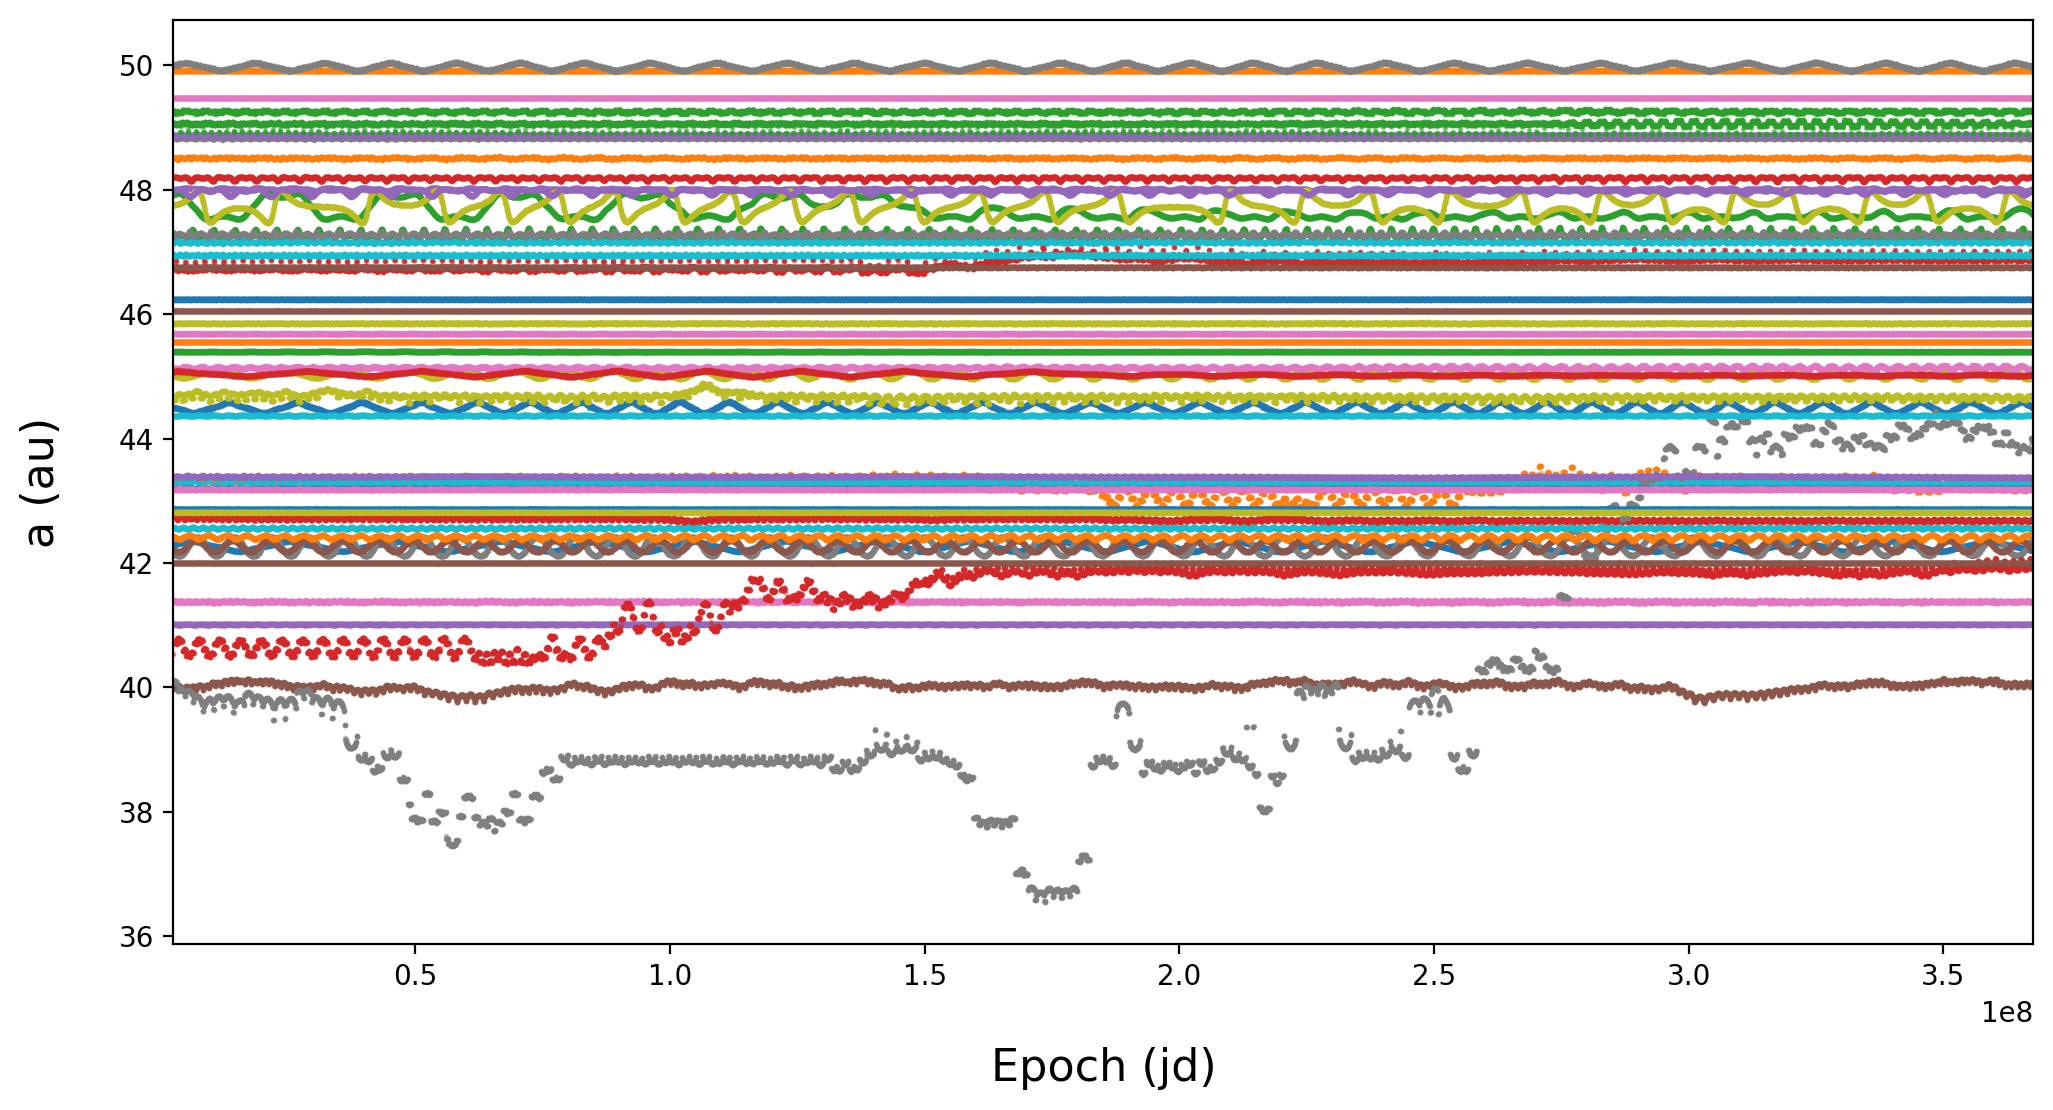

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
for idx in range(N):
    semimajors = [p.a[idx] for p in particle_snapshots]
    epochs = [p[idx].epoch.epoch for p in particle_snapshots]
    
    ax.scatter(epochs, semimajors, s=1, alpha=0.5)

ax.set_xlabel('Epoch (jd)', fontsize=16, labelpad=20)
ax.set_ylabel('a (au)', fontsize=16, labelpad=20)
ax.set_xlim(epochs[0], epochs[-1])

In [10]:
x, y, z = np.ravel([p.x for p in particle_snapshots]), np.ravel([p.y for p in particle_snapshots]), np.ravel([p.z for p in particle_snapshots])
px, py, pz = np.ravel([p.x for p in perturber_snapshots]), np.ravel([p.y for p in perturber_snapshots]), np.ravel([p.z for p in perturber_snapshots])

Text(0, 0.5, 'y (au)')

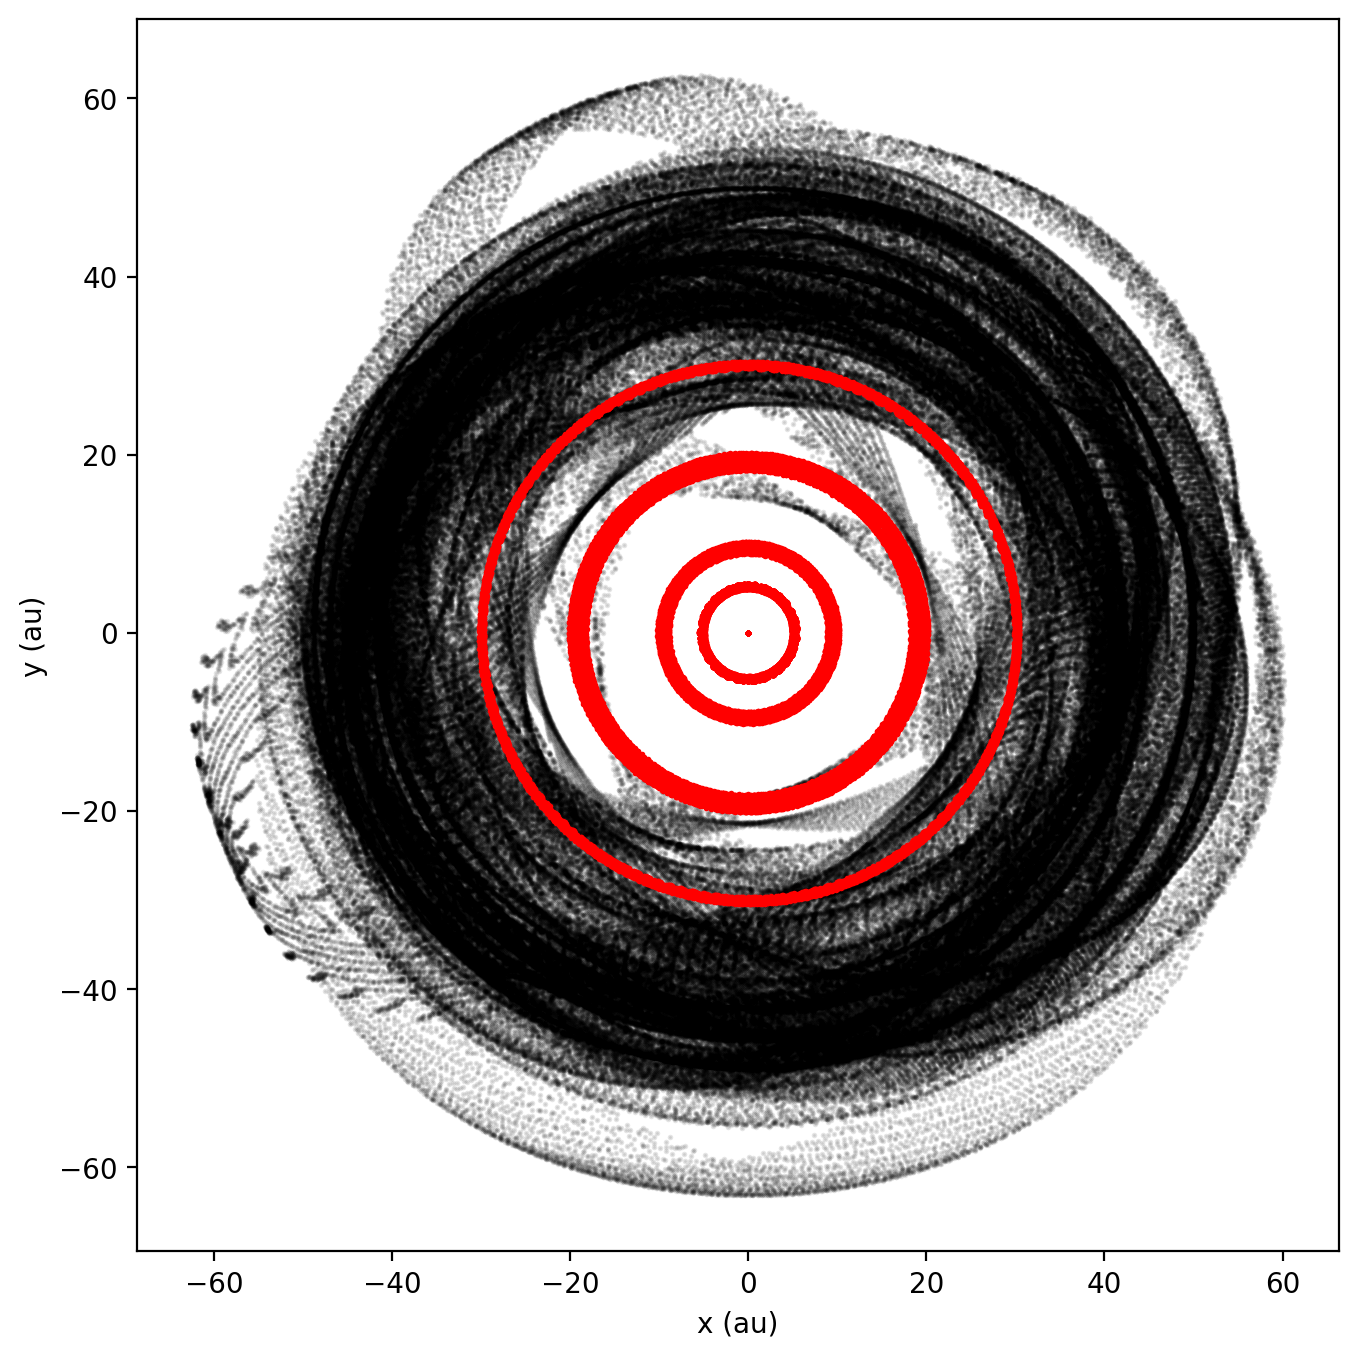

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, s=1, alpha=0.1, color='black')
ax.scatter(px, py, s=1, alpha=1, color='red')
ax.set_aspect('equal')
ax.set_xlabel("x (au)")
ax.set_ylabel("y (au)")

In [12]:
kernel.unload()